In [1]:
import os
import sys
sys.path.append(f"{os.environ['HOME']}/Project/af2rave/")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import af2rave

matplotlib.rcParams.update({"text.usetex": True, 
                            "font.family": "sans-serif",
                            "figure.dpi": 300,
                            "legend.frameon": False})


In [2]:
pdb_dir = f"./datasets/DDR1_MSA8"
ref_pdb = f"{pdb_dir}/pred_1.pdb"
pdb_files = [f"{pdb_dir}/{file}" for file in os.listdir(pdb_dir) if file.endswith('.pdb')]

rMSA = af2rave.features.rMSAAnalysis(pdb_files, ref_pdb)

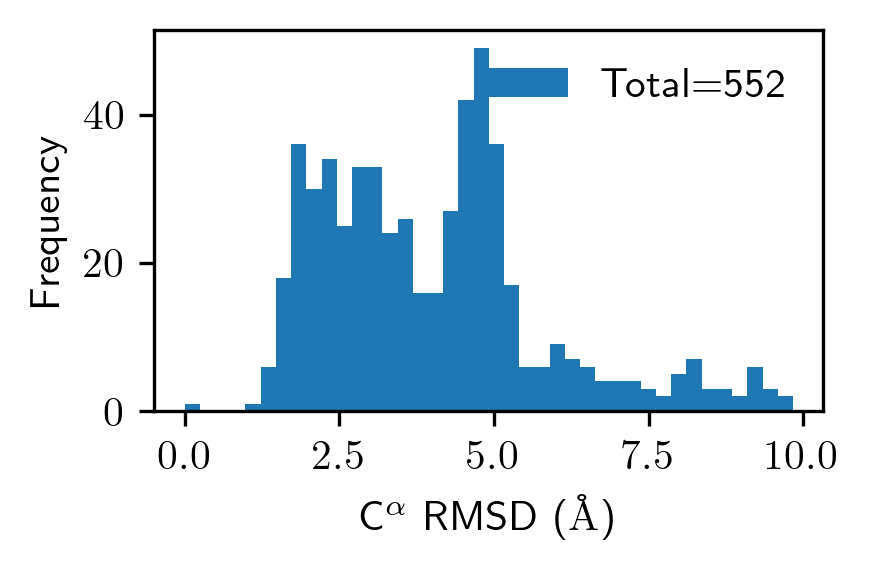

In [3]:
rmsd = rMSA.drop_unphysical_structures(selection="name CA", rmsd_cutoff=10)

fig, ax = plt.subplots(figsize=(3, 2), tight_layout=True)
_ = ax.hist(rmsd, bins=40, label=f"Total={rmsd.shape[0]}")
ax.set_xlabel("C$^\\alpha$ RMSD ($\mathrm \AA$)")
ax.set_ylabel("Frequency")
# ax.set_xlim(0, 10)
ax.legend()

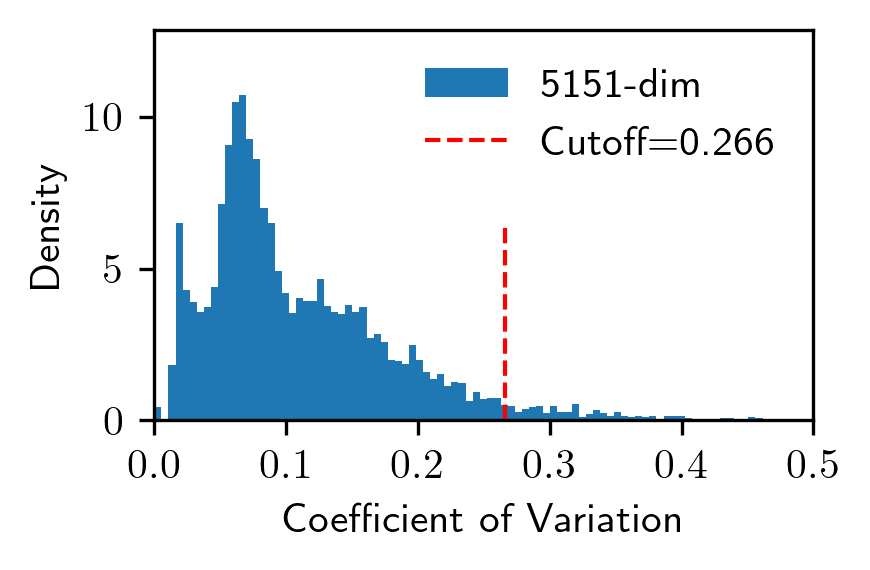

In [4]:
fig, ax = plt.subplots(figsize=(3, 2), tight_layout=True)

n_features = 200
atom_set = ["resid 52 to 81 and name CA",
            "resid 162 to 224 and name CA",
            "resid 185 and name CB CG",    # DFG-Asp
            "resid 186 and name CZ CG",    # DFG-Phe
            "resid 187 and name O",        # DFG-Gly
            "resid 73 and name CD",        # ChelE
            "resid 56 and name CB CZ NZ",  # SB-K
            "resid 171 and name N"         # SB-R
            ]      

selection = " or ".join([f"({atom})" for atom in atom_set])
feature, atom_pairs, cv = rMSA.rank_features(selection=selection)

counts, _, _ = ax.hist(cv, bins=100, label=f"{len(atom_pairs)}-dim", density=True)
cv_cutoff = cv[n_features]
ax.vlines(cv_cutoff, 0, np.max(counts)*0.6, color="red", linestyle="--", linewidth=1, label=f"Cutoff={cv_cutoff:.3f}")

ax.set_ylim(0, np.max(counts)*1.2)
ax.set_xlabel("Coefficient of Variation")
ax.set_ylabel("Density")
ax.set_xlim(0, 0.5)
ax.legend()

In [5]:
print(rMSA.get_chimera_plotscript(atom_pairs[:n_features]))
#print(atom_pairs[:n_features])

open ./datasets/DDR1_MSA8/pred_1.pdb
distance :164@CA :192@CA
distance :163@CA :192@CA
distance :163@CA :193@CA
distance :164@CA :191@CA
distance :164@CA :193@CA
distance :165@CA :192@CA
distance :165@CA :190@CA
distance :193@CA :223@CA
distance :193@CA :222@CA
distance :165@CA :191@CA
distance :164@CA :190@CA
distance :163@CA :194@CA
distance :165@CA :193@CA
distance :193@CA :221@CA
distance :198@CA :206@CA
distance :163@CA :191@CA
distance :198@CA :208@CA
distance :201@CA :220@CA
distance :195@CA :221@CA
distance :200@CA :220@CA
distance :199@CA :206@CA
distance :166@CA :190@CA
distance :196@CA :221@CA
distance :192@CA :223@CA
distance :199@CA :220@CA
distance :74@CD :188@CA
distance :194@CA :221@CA
distance :163@CA :195@CA
distance :192@CA :222@CA
distance :81@CA :187@CZ
distance :198@CA :221@CA
distance :197@CA :208@CA
distance :193@CA :224@CA
distance :164@CA :194@CA
distance :77@CA :192@CA
distance :198@CA :207@CA
distance :196@CA :220@CA
distance :198@CA :220@CA
distance :197@CA

In [6]:
reduced_atom_pairs = rMSA.reduce_features(atom_pairs[:n_features], 20, bins=50, kde_bandwidth=0.02)
print(rMSA.get_chimera_plotscript(reduced_atom_pairs))

open ./datasets/DDR1_MSA8/pred_1.pdb
distance :74@CA :188@CA
distance :200@CA :222@CA
distance :168@CA :208@CA
distance :196@CA :219@CA
distance :199@CA :219@CA



In [7]:
from sklearn.decomposition import PCA

# Configuations for PCA
pca = PCA(n_components=30)
pca_result = pca.fit_transform(feature)

23 clusters identified.


Text(0, 0.5, 'PC2')

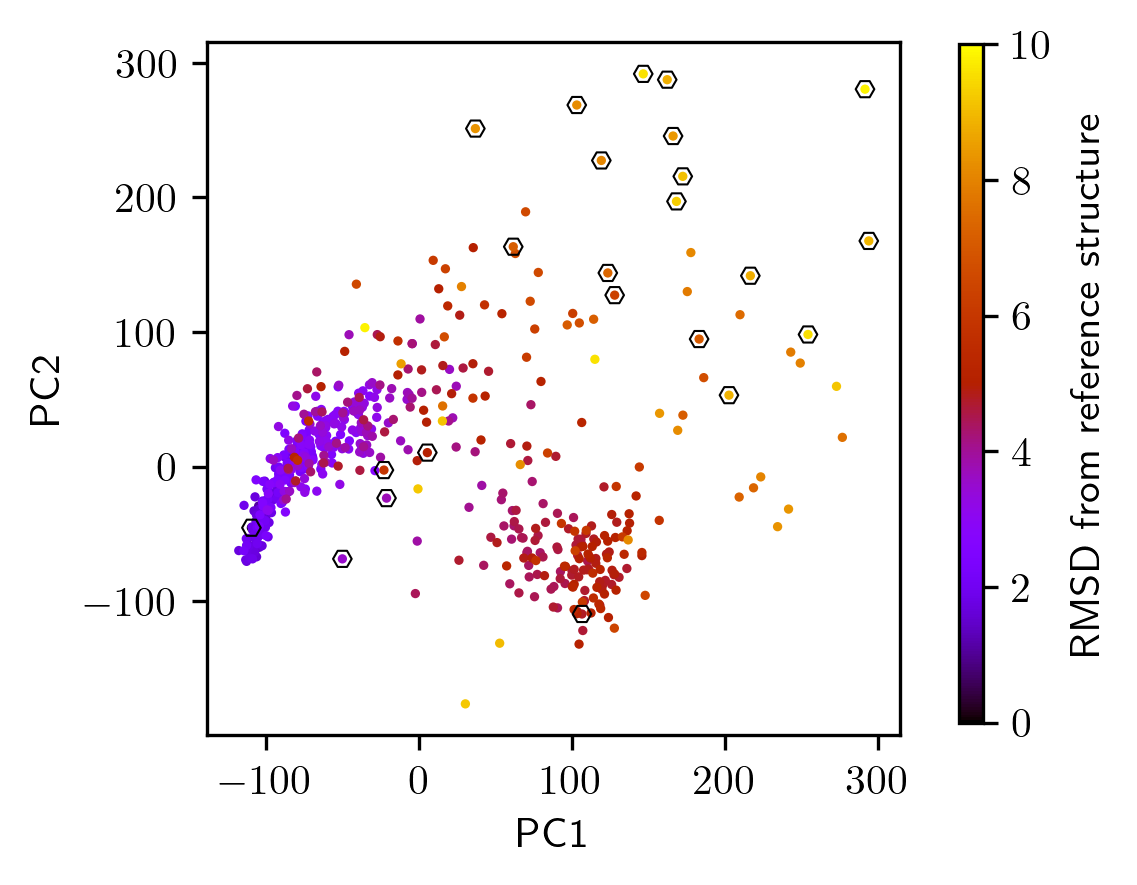

In [9]:
center_list, center_id = rMSA.regular_space_clustering(atom_pairs[:n_features], 5.0, max_centers=100, batch_size=100, randomseed=0)
print(f"{center_list.shape[0]} clusters identified.")

# Plotting 
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
ax.set_box_aspect(1)

scatter_kwargs = {"s": 5, 
                  "c": rmsd, 
                  "cmap": "gnuplot", 
                  "norm": "linear", 
                  "edgecolors": "none",
                  "vmin": 0.0,
                  "vmax": 10.0}

cbar = ax.scatter(pca_result[:,0], pca_result[:,1], **scatter_kwargs)
cb_ax = fig.add_axes([.85,.124,.02,.754])
fig.colorbar(cbar, orientation='vertical', cax=cb_ax)
cb_ax.set_ylabel("RMSD from reference structure", loc="center")

# cluster center in PC space
pca_cc = pca.transform(feature[center_id])

cc_kwargs = {"s": 20, 
             "edgecolor": "black",
             "marker": "H",
             "facecolor": "None", 
             "linewidth": 0.5}
ax.scatter(pca_cc[:,0], pca_cc[:,1], **cc_kwargs)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

pred_1.pdb
pred_192.pdb
pred_573.pdb
pred_481.pdb
pred_544.pdb
pred_257.pdb
pred_542.pdb
pred_81.pdb
pred_506.pdb
pred_558.pdb
pred_432.pdb
pred_449.pdb
pred_491.pdb
pred_559.pdb
pred_557.pdb
pred_580.pdb
pred_512.pdb
pred_567.pdb
pred_441.pdb
pred_603.pdb
pred_533.pdb
pred_514.pdb
pred_575.pdb


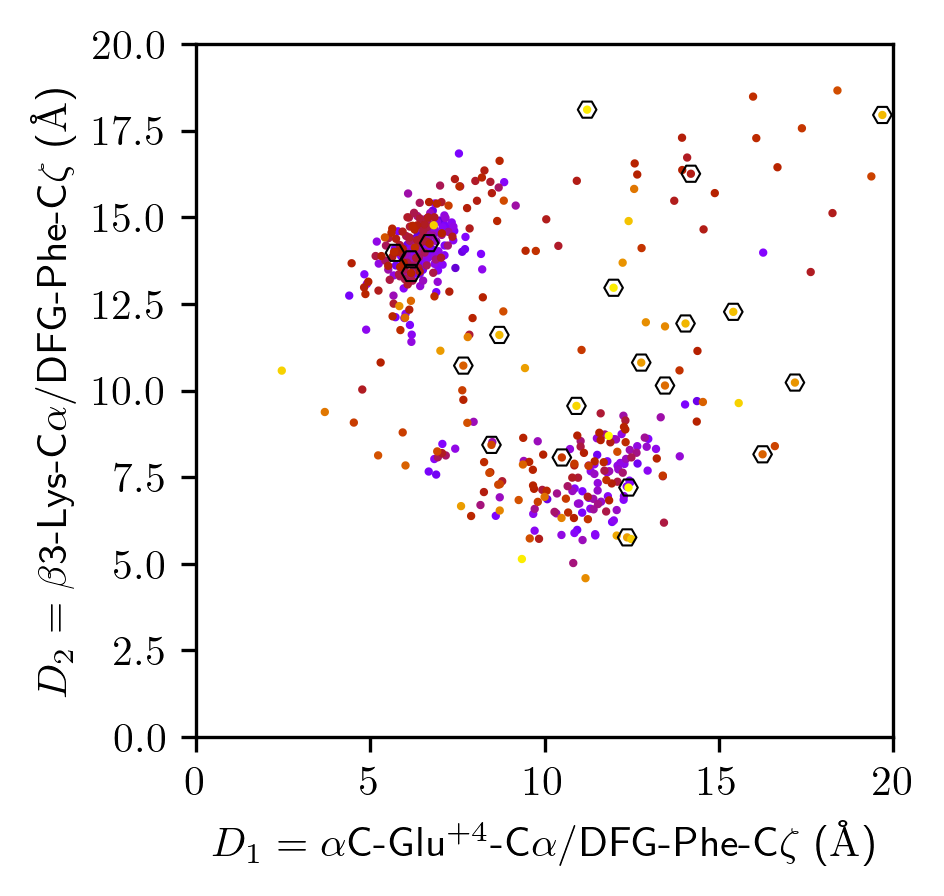

In [10]:
tag_dfg_phe_cz = rMSA.traj.top.select("resid 186 and name CZ")[0]
tag_ac_glu4_ca = rMSA.traj.top.select("resid 77 and name CA")[0]
tag_k_cons_ca = rMSA.traj.top.select("resid 56 and name CA")[0]

d1 = rMSA.get_feature(frozenset([tag_ac_glu4_ca, tag_dfg_phe_cz]))
d2 = rMSA.get_feature(frozenset([tag_k_cons_ca, tag_dfg_phe_cz]))

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(d1, d2, s=1, c=rmsd, cmap="gnuplot")
ax.scatter(d1[center_id], d2[center_id], **cc_kwargs)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel(r"$D_1 = \alpha$C-Glu$^{+4}$-C$\alpha$/DFG-Phe-C$\zeta$ ($\mathrm \AA$)")
ax.set_ylabel(r"$D_2 = \beta$3-Lys-C$\alpha$/DFG-Phe-C$\zeta$ ($\mathrm \AA$)")

starting_structures = [rMSA.pdb_name[i].split("/")[-1] for i in center_id]
for s in starting_structures:
    print(s)

(0.0, 1.0)

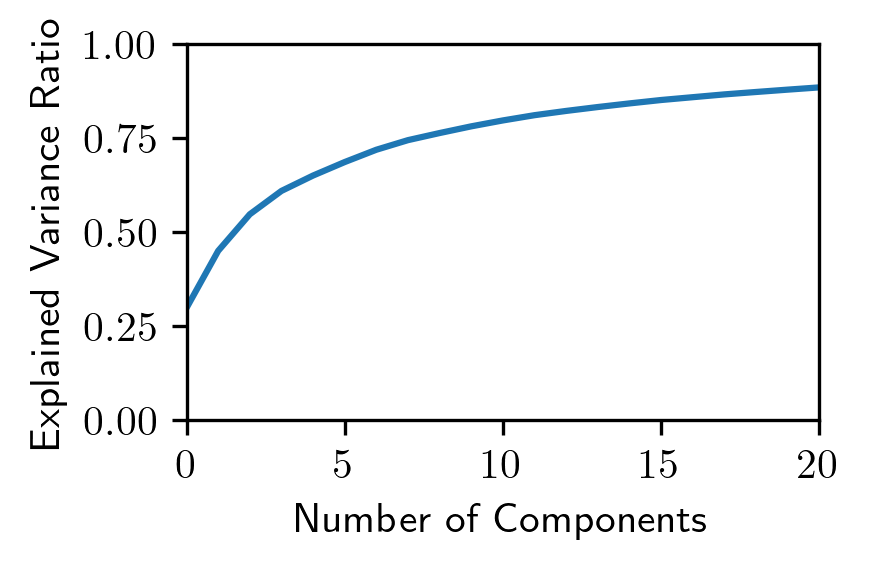

In [ ]:
fig, ax = plt.subplots(figsize=(3,2), dpi=300, tight_layout=True)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance Ratio")
ax.set_xlim(0, 20)
ax.set_ylim(0, 1)

from af2rave.simulation import create_simulation_box
from sys import stdout

import openmm.app as app
from openmm.unit import angstrom, picosecond, kelvin
from openmm import LangevinMiddleIntegrator

ff = app.ForceField("charmm36.xml", "charmm36/water.xml")

for i in starting_structures:
    try:
        create_simulation_box(f"{pdb_dir}/{i}", ff, outfile=f"{pdb_dir}/../DDR1_box/{i}")
    except:
        print(i)


In [4]:
from af2rave import spib
spib.main()

TypeError: main() missing 3 required positional arguments: 'traj', 'label', and 'dt_list'